# <font color="orange">Fine-tunning с использованием библиотеки HuggingFace</font>

## Какой эксперимент здесь проводится.  

- Берем набор текстов (5 000) на русском языке на различные темы (политика, спорт, культура, пр.), которые были векторизованы под определенную модель (<font color="lightgreen">__rubert-tiny2__</font>), или - получены их эмбеддинги (с учетом self-attantion!).  
- Далее, тексты были кластеризованы методом __Agglomerative_classifier__, где в качестве признаков выступали эмбеддинги, и т.о. были получены псевдо-метки. В итоге, мы получили набор данных: тексты, эмбеддинги, метки.  
- Берем из этих данных _текст_ и _псевдо-метки_ и на них дообучаем модель.   
- Делаем предсказание на дообученной модели, получаем новые псевдо-метки. Заодно оцениваем точность классификации.  
- Таким образом, мы, имея в качестве "истинных" меток псевдо-метки, полученные методом кластеризации Agglomerative_classifier, дообучаем модель и делаем на дообученной модели предсказание.   
- Учитывая, что мы получили метки в результате кластеризации Agglomerative_classifier (классификатор без учителя, работающий на определенном принципе формирования классов), то  интересно взглянуть на то, как модель может дообучиться/подстроиться под данную разметку, показывав хорошую точность.

## Кое-какая теория

__Классификация с учителем на основе нейронных сетей__ — это мощный и гибкий подход, особенно если данные большие и имеют сложную структуру (например, тексты, изображения или временные ряды). Вот обзор основных реализаций нейросетевых классификаторов, их типов и особенностей:

🧠 _1. Простая полносвязная нейронная сеть (MLP — Multi-Layer Perceptron)_  
Где применимо: числовые признаки, табличные данные, базовая текстовая классификация после векторизации (TF-IDF, word2vec).  
Особенности:  
Работает как классические классификаторы, но мощнее при большом количестве признаков.  
Плохо масштабируется на длинные тексты и последовательности без специальной архитектуры.  

📄 _2. Нейросети для текстов: Embedding + RNN/LSTM/GRU/Transformer_  
Где применимо: классификация длинных и сложных текстов.  
Особенности:  
Требует токенизации и индексации текста.  
Обучается с нуля, или использует предобученные эмбеддинги (GloVe, FastText).  

🚀 _3. Transformer-модели (BERT, RoBERTa и др.)_  
Где применимо: высокоточная классификация текстов, особенно с богатым языком (русский, английский).
Особенности:  
Использует предобученные модели.  
Отлично работает на задачах классификации длинных текстов, требует GPU.  

⚙️ _4. Глубокие сверточные сети (CNN)_  
Где применимо: изображение, иногда текст (сжатый), биоинформатика.  

📊 <u>Сравнение с классическими классификаторами</u>  
__KNN, SVC, LR__
Малые/средние данные, табличные
Простота, не требует много данных

__MLP (sklearn)__
Табличные данные, векторизованные тексты
Хорошая альтернатива классике

__LSTM/GRU__
Последовательности, тексты
Учитывает порядок слов

__Transformer__
Сложные тексты, многоклассовая классификация
State-of-the-art, требует вычислений

__CNN__
Изображения, пиксельные данные
Пространственные зависимости  

#### Объяснение ключевых шагов:
1. Загрузка:  
Используем AutoTokenizer и AutoModelForSequenceClassification для загрузки модели и токенизатора cointegrated/rubert-tiny2.
Проверка GPU: В Google Colab автоматически будет использован GPU, если он доступен, с помощью команды torch.device("cuda" if torch.cuda.is_available() else "cpu").
2. Токенизация:  
Тексты токенизируются в формате, подходящем для модели (с добавлением паддинга и обрезкой до максимальной длины 256).  
3. Обучение:  
Используется Trainer из transformers для обучения модели на псевдоразметке с использованием переданных аргументов обучения (TrainingArguments).  
3. Предсказания:  
После обучения модель используется для предсказания новых меток для всех текстов, которые подаются через функцию predict_pseudo_labels.  


# Код

In [ ]:
!pip install transformers datasets

In [ ]:
# !pip install --upgrade transformers
# !pip show transformers
# print(TrainingArguments.__module__)

# from transformers import TrainingArguments
# import inspect
# print(inspect.signature(TrainingArguments.__init__))

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader

In [8]:
import torch

In [12]:
from datasets import Dataset

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
# Связь с файлами на Google drıve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Подготовка данных

num_object = 5000 # С каким файлом по объему выбранного текста будем работать
# _________Google Colab___________
output_file = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_AgglCl_{num_object}.csv'

# __________Локально_____________
# output_file_short = f"./Data/clusters_rubert-tiny2_KMeans_{num_object}.csv"

df = pd.read_csv(output_file, encoding="utf-8") # Читаем файл (текст, эмбеддинги, псевдо-метки)
print(df.head(2))

texts = df['text']  # Исходные тексты
pseudo_labels = df['cluster']  # Псевдораспределения из кластеризации
num_labels = len(set(pseudo_labels))  # Количество классов
print(num_labels)

## Fine-tuning, prediction...

In [6]:
# Разделение на обучающую и валидационную выборки
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, pseudo_labels, test_size=0.2, random_state=42, stratify=pseudo_labels
)
# stratify=pseudo_labels	- Стратифицированная выборка — сохраняет пропорции классов в обучении и валидации

In [7]:
# Загрузка модели и токенизатора
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Проверка на наличие GPU в Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [13]:
# Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [17]:
# Настройка аргументов обучения
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=False,
    report_to="none",
    fp16=True,  # Использование 16-битной точности для ускорения на GPU
    gradient_accumulation_steps=2  # Для больших данных увеличиваем градиентный аккумулятор
)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [23]:
# Запуск обучения
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.440700,0.606311
2,0.403000,0.588598
3,0.391600,0.584887


TrainOutput(global_step=375, training_loss=0.41756597137451174, metrics={'train_runtime': 33.4463, 'train_samples_per_second': 358.784, 'train_steps_per_second': 11.212, 'total_flos': 44291395584000.0, 'train_loss': 0.41756597137451174, 'epoch': 3.0})

In [24]:
# Предсказание новых псевдо-меток
def predict_pseudo_labels(texts):
  # tokenizer ожидает список строк, а у нас он имеет тип "pandas.Series"
  # поэтому преобразуй Series в список -> .tolist()
  texts_list = df['text'].tolist()

  # Настройки
  batch_size = 128
  all_preds = []

  # Обработка батчами
  for i in tqdm(range(0, len(texts_list), batch_size)):
    batch_texts = texts_list[i:i + batch_size]

    # Токенизация батча
    tokenized = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=256
    )

    tokenized = {k: v.to(device) for k, v in tokenized.items()}

    # Предсказание
    with torch.no_grad():
        outputs = model(**tokenized)
        predictions = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(predictions.cpu().numpy())
  # Финальный массив псевдо меток
  n_pseudo_labels = np.array(all_preds)

  return n_pseudo_labels

  print("Получено меток:", len(n_pseudo_labels))

In [25]:
 new_pseudo_labels = predict_pseudo_labels(texts)
 new_pseudo_labels

100%|██████████| 40/40 [00:09<00:00,  4.13it/s]


array([9, 4, 3, ..., 0, 0, 0])

In [26]:
# Подсчет количества по pseudo_labels
counts_pseudo = pd.Series(pseudo_labels).value_counts().sort_index()
counts_pseudo

,count
cluster,
0,922
1,371
2,203
3,1713
4,226
5,411
6,240
7,227
8,340


In [27]:
# Подсчет количества по новым меткам
counts = pd.Series(new_pseudo_labels).value_counts().sort_index()
counts

,count
0,1073
1,396
2,171
3,1755
4,197
5,426
6,154
7,230
8,332
9,266


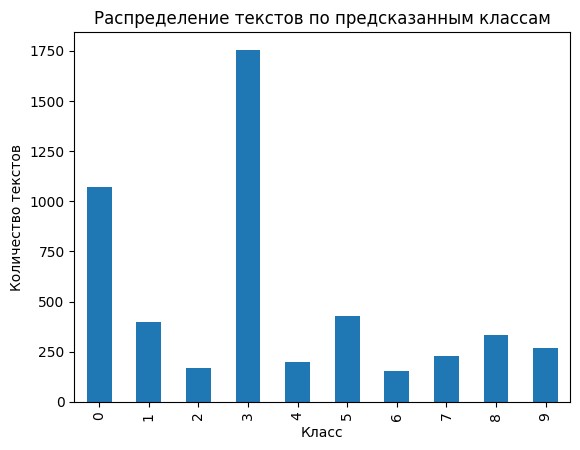

In [28]:
import matplotlib.pyplot as plt

counts.plot(kind='bar')
plt.xlabel("Класс")
plt.ylabel("Количество текстов")
plt.title("Распределение текстов по предсказанным классам")
plt.show()

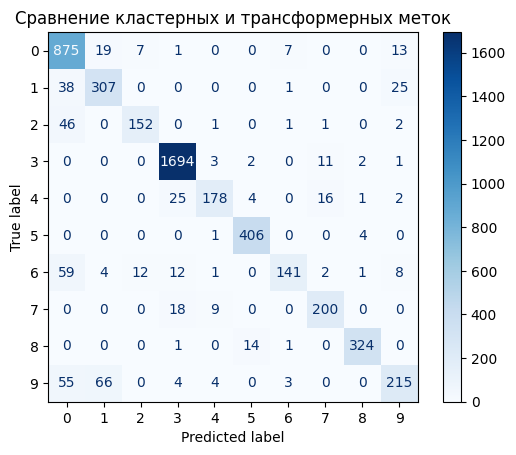

In [29]:
# Матрица ошибок (Confusion Matrix):
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(pseudo_labels, new_pseudo_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Сравнение кластерных и трансформерных меток")
plt.show()

In [30]:
cm

array([[ 875,   19,    7,    1,    0,    0,    7,    0,    0,   13],
       [  38,  307,    0,    0,    0,    0,    1,    0,    0,   25],
       [  46,    0,  152,    0,    1,    0,    1,    1,    0,    2],
       [   0,    0,    0, 1694,    3,    2,    0,   11,    2,    1],
       [   0,    0,    0,   25,  178,    4,    0,   16,    1,    2],
       [   0,    0,    0,    0,    1,  406,    0,    0,    4,    0],
       [  59,    4,   12,   12,    1,    0,  141,    2,    1,    8],
       [   0,    0,    0,   18,    9,    0,    0,  200,    0,    0],
       [   0,    0,    0,    1,    0,   14,    1,    0,  324,    0],
       [  55,   66,    0,    4,    4,    0,    3,    0,    0,  215]])

In [31]:
from sklearn.metrics import classification_report
print(classification_report(pseudo_labels, new_pseudo_labels))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       922
           1       0.78      0.83      0.80       371
           2       0.89      0.75      0.81       203
           3       0.97      0.99      0.98      1713
           4       0.90      0.79      0.84       226
           5       0.95      0.99      0.97       411
           6       0.92      0.59      0.72       240
           7       0.87      0.88      0.88       227
           8       0.98      0.95      0.96       340
           9       0.81      0.62      0.70       347

    accuracy                           0.90      5000
   macro avg       0.89      0.83      0.85      5000
weighted avg       0.90      0.90      0.89      5000



In [32]:
# Метрики согласованности:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari = adjusted_rand_score(pseudo_labels, new_pseudo_labels)
ami = adjusted_mutual_info_score(pseudo_labels, new_pseudo_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Adjusted Mutual Info (AMI): {ami:.4f}")

Adjusted Rand Index (ARI): 0.8603
Adjusted Mutual Info (AMI): 0.8035


In [33]:
# Добавляем столбец  "cluster" в df_subset
df = df.copy()  # Создаем независимую копию
df["cluster_2"] = list(new_pseudo_labels)  # Теперь можно безопасно изменять
df.head()

,text,embedding,cluster,cluster_2
0,Заместитель председателяnправительства РФnСерг...,[ 7.51871914e-02 -5.56178438e-03 1.42403012e-...,9,9
1,Матч 1/16 финала Кубка России по футболу был п...,[ 3.51897063e-04 -4.81031202e-02 -2.03281529e-...,4,4
2,Форвард «Авангарда» Томаш Заборский прокоммент...,[ 0.04424202 0.00478189 -0.02290487 -0.049215...,7,3
3,Главный тренер «Кубани» Юрий Красножан прокомм...,[ 4.73305844e-02 3.10603529e-02 1.54471840e-...,3,3
4,Решением попечительского совета владивостокско...,[ 7.09208325e-02 -5.18195815e-02 -1.78049505e-...,9,4


In [37]:
# Cохранение (текст, эмбеддинги, метки, метки)

# Google Colab
output_file = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_AgglCl_{num_object}_fine.csv'
# Локально
# output_file_short = f"./Data/clusters_rubert-tiny2_KMeans_fine_{num_object}.csv"

df.to_csv(output_file, index=False, encoding="utf-8")
print(f"✅ Кластеры сохранены в {output_file}.")

✅ Кластеры сохранены в /content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_AgglCl_5000_fine.csv.


## <font color='lightgreen'>_-> Визуализация эмбеддингов и кластеров до дообучения._</font>

In [ ]:
df['embedding']

In [41]:
# Признаки (эмбеддинги)

# Преобразуем каждую строку в массив чисел
df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

X_old = np.stack(df['embedding'].to_numpy()) # Преобразуем списка с эмбеддингами в массив чисел
# Метки
y_old = pseudo_labels

print(X_old.shape, X_old.dtype) # Должно быть (количество образцов, размерность эмбеддинга) Должно быть float32 или float64
print(y_old.shape, y_old.dtype) # Должно быть (количество образцов, ) Должно быть int64

(5000, 312) float64
(5000,) int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


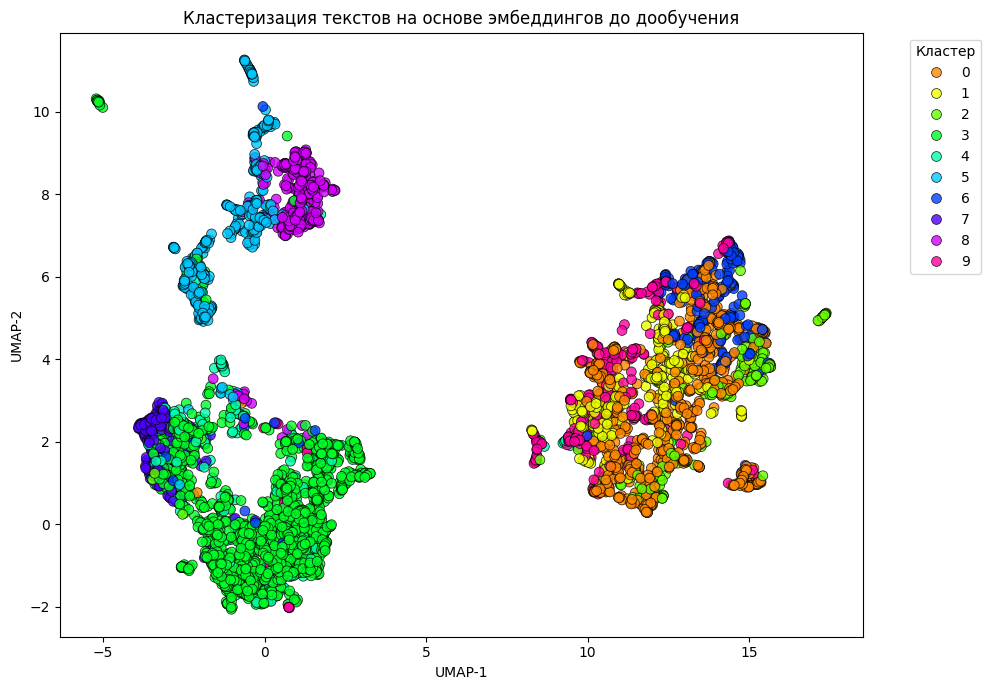

In [42]:
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import pandas as pd

# 1. UMAP проекция
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='cosine', random_state=42) # n_neighbors=15	Сколько ближайших соседей учитывать	(влияет на "локальность" — чем меньше, тем сильнее UMAP фокусируется на локальной структуре),  min_dist=0.1	Минимальная допустимая дистанция между точками (в низкомерном пространстве	чем меньше, тем плотнее группы), metric='cosine'	Метрика расстояния	(cosine лучше работает с эмбеддингами, чем euclidean)
embeddings_2d = reducer.fit_transform(X_old)

# 2. Подготовка DataFrame для визуализации
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': y_old
})
# Визуализация
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(set(y_old)))
sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette=palette, s=50, alpha=0.8, edgecolor='k')
plt.title("Кластеризация текстов на основе эмбеддингов до дообучения")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## <font color='lightgreen'>_-> Визуализация эмбеддингов и кластеров после дообучения._</font>

In [45]:
output_file = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_AgglCl_{num_object}_fine.csv'
df_new = pd.read_csv(output_file, encoding="utf-8") # Читаем файл
print(df_new.head(2))

                                                text  \
0  Заместитель председателяnправительства РФnСерг...   
1  Матч 1/16 финала Кубка России по футболу был п...   

                                           embedding  cluster  cluster_2  
0  [ 7.51871914e-02 -5.56178438e-03  1.42403012e-...        9          9  
1  [ 3.51897063e-04 -4.81031202e-02 -2.03281529e-...        4          4  


In [46]:
type(df_new["embedding"].iloc[0])

str

In [47]:
# Эмбеддинги
# Преобразуем каждую строку в массив чисел
df_new['embedding'] = df_new['embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))
X_new = np.vstack(df_new["embedding"].values) # Преобразуем в numpy-массив
# Метки
y_new = df_new['cluster_2']

print(X_new.shape, X_new.dtype) # Должно быть (количество образцов, размерность эмбеддинга) Должно быть float32 или float64
print(y_new.shape, y_new.dtype) # Должно быть (количество образцов, ) Должно быть int64

(5000, 312) float64
(5000,) int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


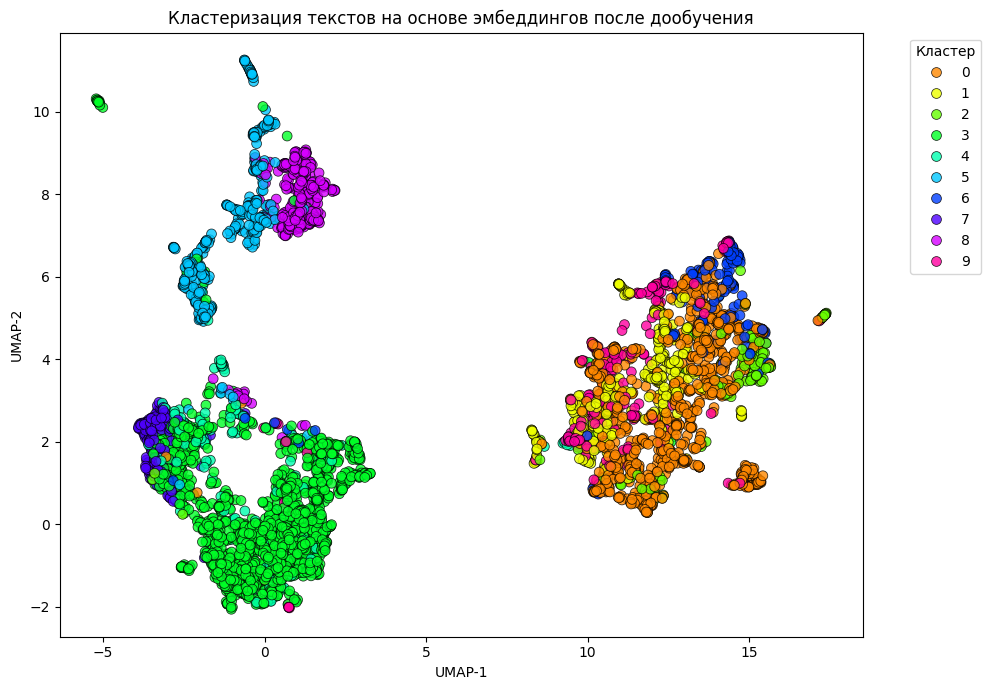

In [48]:
# 1. UMAP проекция
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='cosine', random_state=42) # n_neighbors=15	Сколько ближайших соседей учитывать	(влияет на "локальность" — чем меньше, тем сильнее UMAP фокусируется на локальной структуре),  min_dist=0.1	Минимальная допустимая дистанция между точками (в низкомерном пространстве	чем меньше, тем плотнее группы), metric='cosine'	Метрика расстояния	(cosine лучше работает с эмбеддингами, чем euclidean)
embeddings_2d = reducer.fit_transform(X_new)

# 2. Подготовка DataFrame для визуализации
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': y_new
})
# Визуализация
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(set(y_new)))
sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette=palette, s=50, alpha=0.8, edgecolor='k')
plt.title("Кластеризация текстов на основе эмбеддингов после дообучения")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()